In [1]:
import numpy as np
with open('../data/expr.tsv') as f:
    sum_of_means = 0
    for line in f:
        sum_of_means += np.mean(np.fromstring(line, dtype=int, sep='\t'))
print(sum_of_means)

1463.0


<ipython-input-1-7e3315113368>:5: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  sum_of_means += np.mean(np.fromstring(line, dtype=int, sep='\t'))


In [2]:
import numpy as np
expr = np.loadtxt('../data/expr.tsv')
logexpr = np.log(expr + 1)
np.mean(logexpr, axis=0)

array([3.11797294, 2.48682887, 2.19580049, 2.36001866, 2.70124539,
       2.64721531, 2.43704834, 3.28539133, 2.05363724, 2.37151577,
       3.85450782, 3.9488385 , 2.46680157, 2.36334423, 3.18381635,
       2.64438124, 2.62966516, 2.84790568, 2.61691451, 4.12513405])

In [3]:
def log_all_standard(input):
    output = []
    for elem in input:
        output.append(np.log(elem))
    return output

def log_all_streaming(input_stream):
    for elem in input_stream:
        yield np.log(elem)

In [4]:
# We set the random seed so we will get consistent results
np.random.seed(seed=7)
# Set print options to show only 3 significant digits
np.set_printoptions(precision=3, suppress=True)

arr = np.random.rand(1000) + 0.5
result_batch = sum(log_all_standard(arr))
print('Batch result: ', result_batch)
result_stream = sum(log_all_streaming(arr))
print('Stream result: ', result_stream)

Batch result:  -48.2409194560661
Stream result:  -48.2409194560661


In [5]:
import numpy as np

def tsv_line_to_array(line):
    lst = [float(elem) for elem in line.rstrip().split('\t')]
    return np.array(lst)

def readtsv(filename):
    print('starting readtsv')
    with open(filename) as fin:
        for i, line in enumerate(fin):
            print(f'reading line {i}')
            yield tsv_line_to_array(line)
    print('finished readtsv')

def add1(arrays_iter):
    print('starting adding 1')
    for i, arr in enumerate(arrays_iter):
        print(f'adding 1 to line {i}')
        yield arr + 1
    print('finished adding 1')

def log(arrays_iter):
    print('starting log')
    for i, arr in enumerate(arrays_iter):
        print(f'taking log of array {i}')
        yield np.log(arr)
    print('finished log')

def running_mean(arrays_iter):
    print('starting running mean')
    for i, arr in enumerate(arrays_iter):
        if i == 0:
            mean = arr
        mean += (arr - mean) / (i + 1)
        print(f'adding line {i} to the running mean')
    print('returning mean')
    return mean

In [6]:
fin = '../data/expr.tsv'
print('Creating lines iterator')
lines = readtsv(fin)
print('Creating loglines iterator')
loglines = log(add1(lines))
print('Computing mean')
mean = running_mean(loglines)
print(f'the mean log-row is: {mean}')

Creating lines iterator
Creating loglines iterator
Computing mean
starting running mean
starting log
starting adding 1
starting readtsv
reading line 0
adding 1 to line 0
taking log of array 0
adding line 0 to the running mean
reading line 1
adding 1 to line 1
taking log of array 1
adding line 1 to the running mean
reading line 2
adding 1 to line 2
taking log of array 2
adding line 2 to the running mean
reading line 3
adding 1 to line 3
taking log of array 3
adding line 3 to the running mean
reading line 4
adding 1 to line 4
taking log of array 4
adding line 4 to the running mean
finished readtsv
finished adding 1
finished log
returning mean
the mean log-row is: [3.118 2.487 2.196 2.36  2.701 2.647 2.437 3.285 2.054 2.372 3.855 3.949
 2.467 2.363 3.184 2.644 2.63  2.848 2.617 4.125]


In [7]:
import toolz as tz
from toolz import curried as c
from glob import glob
import itertools as it

LDICT = dict(zip('ACGTacgt', range(8)))
PDICT = {(a, b): (LDICT[a], LDICT[b])
         for a, b in it.product(LDICT, LDICT)}

def is_sequence(line):
    return not line.startswith('>')

def is_nucleotide(letter):
    return letter in LDICT  # ignore 'N'

@tz.curry
def increment_model(model, index):
    model[index] += 1


def genome(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(open),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))


def markov(seq):
    """Get a 1st-order Markov model from a sequence of nucleotides."""
    model = np.zeros((8, 8))
    tz.last(tz.pipe(seq,
                    c.sliding_window(2),        # each successive tuple
                    c.map(PDICT.__getitem__),   # location in matrix of tuple
                    c.map(increment_model(model))))  # increment matrix
    # convert counts to transition probability matrix
    model /= np.sum(model, axis=1)[:, np.newaxis]
    return model

In [8]:
%%timeit -r 1 -n 1
dm = '../data/dm6.fa'
model = tz.pipe(dm, genome, c.take(10**7), markov)
# we use `take` to just run on the first 10 million bases, to speed things up.
# the take step can just be removed if you have ~5-10 mins to wait.

7.73 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
import toolz as tz
filename = '../data/expr.tsv'
mean = tz.pipe(filename, readtsv, add1, log, running_mean)

# This is equivalent to nesting the functions like this:
# running_mean(log(add1(readtsv(filename))))

starting running mean
starting log
starting adding 1
starting readtsv
reading line 0
adding 1 to line 0
taking log of array 0
adding line 0 to the running mean
reading line 1
adding 1 to line 1
taking log of array 1
adding line 1 to the running mean
reading line 2
adding 1 to line 2
taking log of array 2
adding line 2 to the running mean
reading line 3
adding 1 to line 3
taking log of array 3
adding line 3 to the running mean
reading line 4
adding 1 to line 4
taking log of array 4
adding line 4 to the running mean
finished readtsv
finished adding 1
finished log
returning mean


In [10]:
def is_sequence(line):
    line = line.rstrip()  # remove '\n' at end of line
    return len(line) > 0 and not line.startswith('>')

def reads_to_kmers(reads_iter, k=7):
     for read in reads_iter:
         for start in range(0, len(read) - k):
             yield read[start : start + k]  # note yield, so this is a generator

def kmer_counter(kmer_iter):
    counts = {}
    for kmer in kmer_iter:
        if kmer not in counts:
            counts[kmer] = 0
        counts[kmer] += 1
    return counts

with open('../data/sample.fasta') as fin:
    reads = filter(is_sequence, fin)
    kmers = reads_to_kmers(reads)
    counts = kmer_counter(kmers)

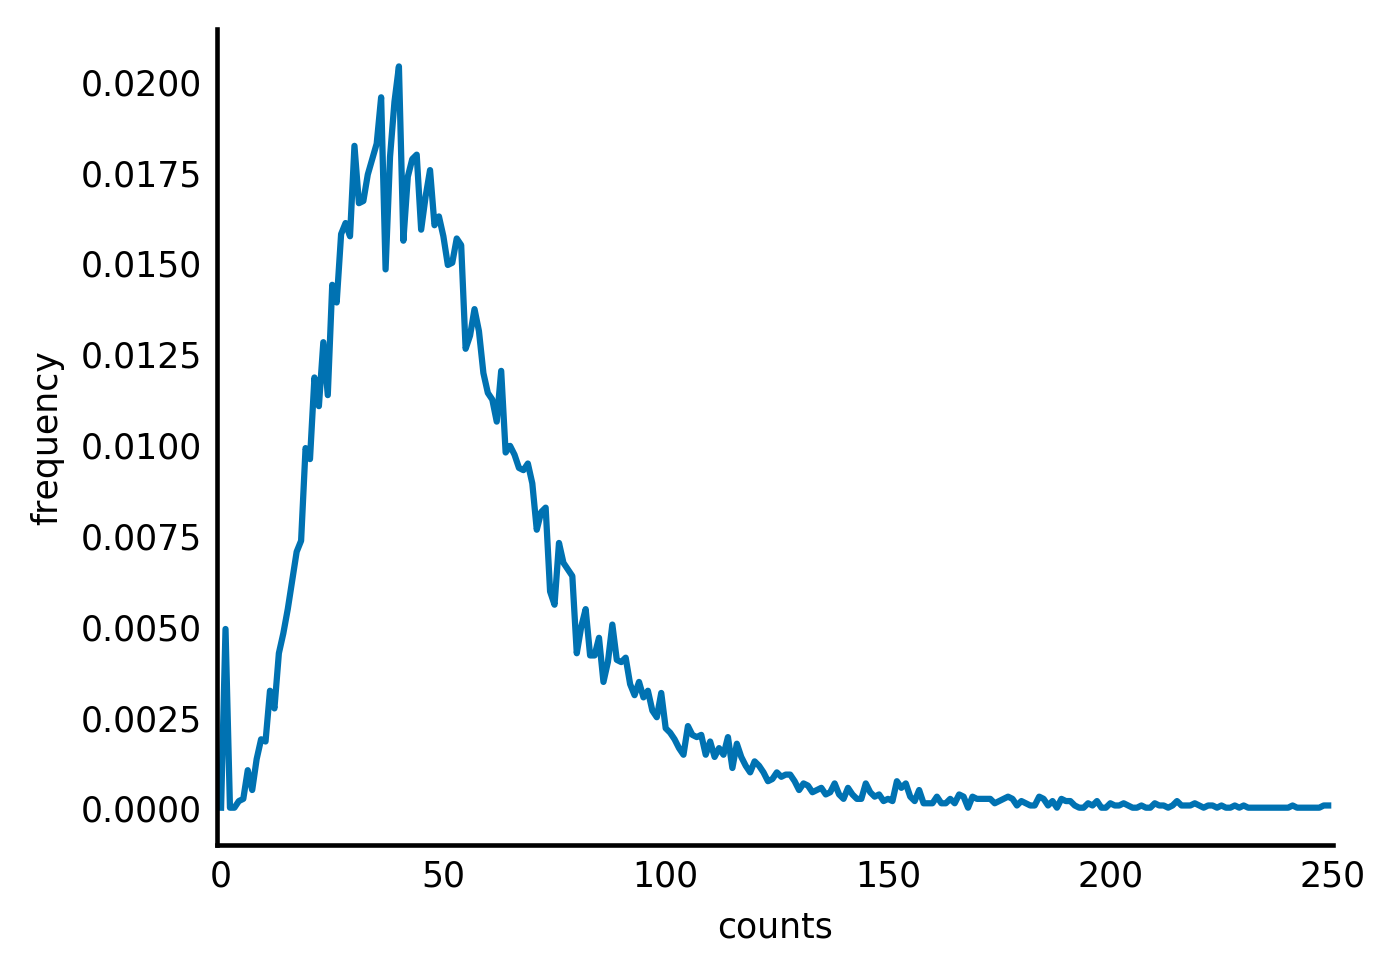

In [11]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

def integer_histogram(counts, normed=True, xlim=[], ylim=[],
                      *args, **kwargs):
    hist = np.bincount(counts)
    if normed:
        hist = hist / np.sum(hist)
    fig, ax = plt.subplots()
    ax.plot(np.arange(hist.size), hist, *args, **kwargs)
    ax.set_xlabel('counts')
    ax.set_ylabel('frequency')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

counts_arr = np.fromiter(counts.values(), dtype=int, count=len(counts))
integer_histogram(counts_arr, xlim=(-1, 250))


In [12]:
print(tz.sliding_window.__doc__)

 A sequence of overlapping subsequences

    >>> list(sliding_window(2, [1, 2, 3, 4]))
    [(1, 2), (2, 3), (3, 4)]

    This function creates a sliding window suitable for transformations like
    sliding means / smoothing

    >>> mean = lambda seq: float(sum(seq)) / len(seq)
    >>> list(map(mean, sliding_window(2, [1, 2, 3, 4])))
    [1.5, 2.5, 3.5]
    


In [13]:
from toolz import curried as c

k = 7
counts = tz.pipe('data/sample.fasta', open,
                 c.filter(is_sequence),
                 c.map(str.rstrip),
                 c.map(c.sliding_window(k)),
                 tz.concat, c.map(''.join),
                 tz.frequencies)

FileNotFoundError: [Errno 2] No such file or directory: 'data/sample.fasta'

In [14]:
def add(a, b):
    return a + b

add(2, 5)

7

In [15]:
def add_curried(a, b=None):
    if b is None:
        # second argument not given, so make a function and return it
        def add_partial(b):
            return add(a, b)
        return add_partial
    else:
        # Both values were given, so we can just return a value
        return add(a, b)

In [16]:
add_curried(2, 5)

7

In [17]:
add_curried(2)

<function __main__.add_curried.<locals>.add_partial(b)>

In [18]:
add2 = add_curried(2)
add2(5)

7

In [19]:
import toolz as tz

@tz.curry  # Use curry as a decorator
def add(x, y):
    return x + y

add_partial = add(2)
add_partial(5)

7

In [20]:
from toolz import curried as c
c.map

<class 'map'>

In [21]:
def genome(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(open),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))

In [23]:
from toolz import curried as c

k = 7
counts = tz.pipe('../data/sample.fasta', open,
                 c.filter(is_sequence),
                 c.map(str.rstrip),
                 c.map(c.sliding_window(k)),
                 tz.concat, c.map(''.join),
                 tz.frequencies)

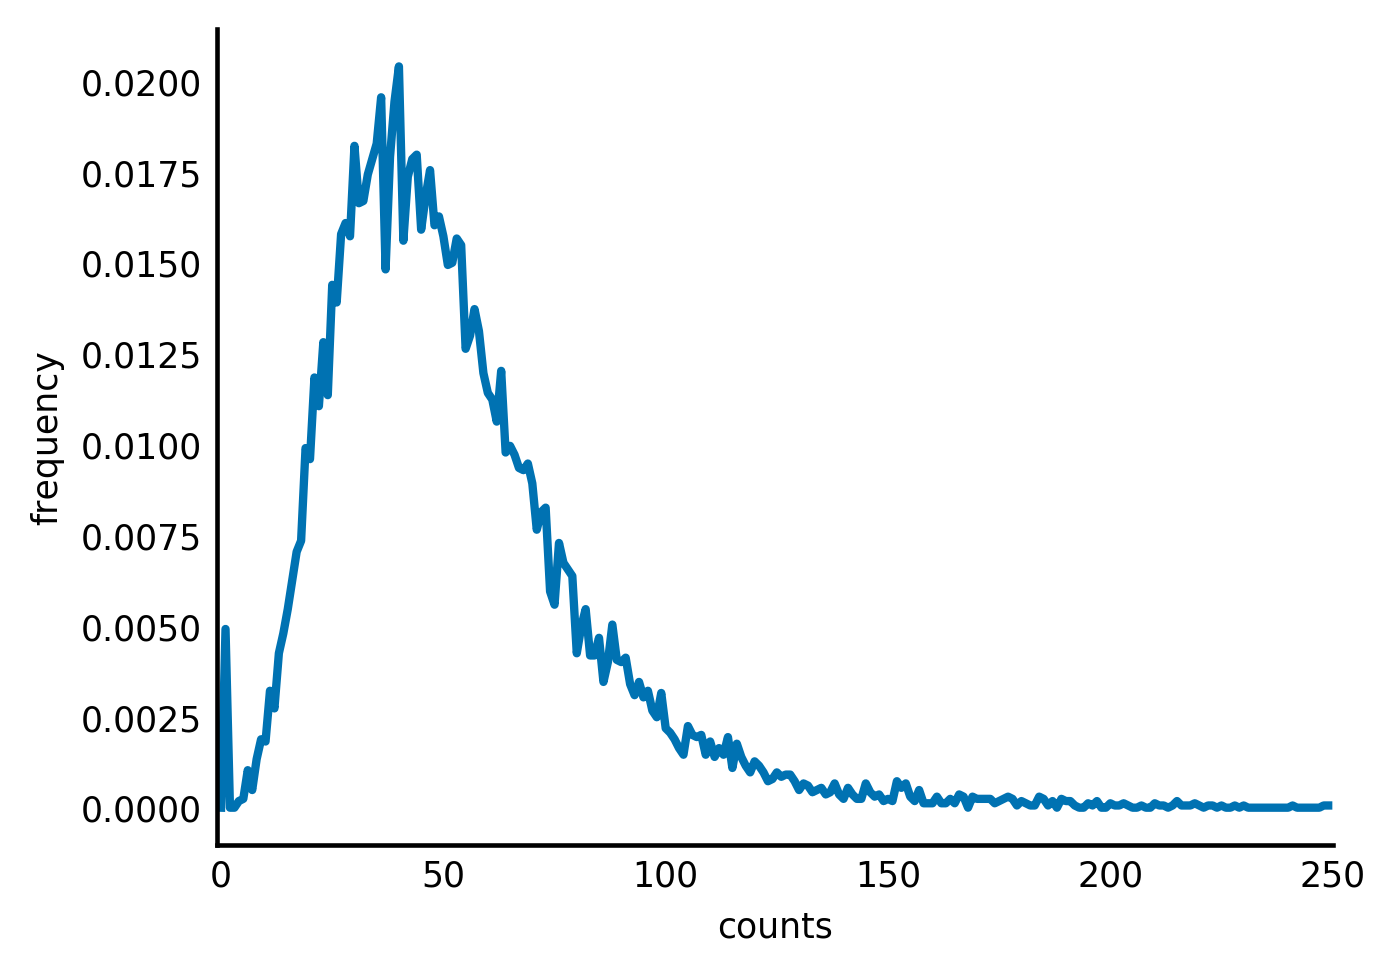

In [24]:
counts = np.fromiter(counts.values(), dtype=int, count=len(counts))
integer_histogram(counts, xlim=(-1, 250), lw=2)

In [25]:
import itertools as it

LDICT = dict(zip('ACGTacgt', range(8)))
PDICT = {(a, b): (LDICT[a], LDICT[b])
         for a, b in it.product(LDICT, LDICT)}

In [26]:
def is_sequence(line):
    return not line.startswith('>')

def is_nucleotide(letter):
    return letter in LDICT  # ignore 'N'

In [27]:
import toolz as tz

@tz.curry
def increment_model(model, index):
    model[index] += 1

In [28]:
from toolz import curried as c

def markov(seq):
    """Get a 1st-order Markov model from a sequence of nucleotides."""
    model = np.zeros((8, 8))
    tz.last(tz.pipe(seq,
                    c.sliding_window(2),        # each successive tuple
                    c.map(PDICT.__getitem__),   # location in matrix of tuple
                    c.map(increment_model(model))))  # increment matrix
    # convert counts to transition probability matrix
    model /= np.sum(model, axis=1)[:, np.newaxis]
    return model

In [29]:
from glob import glob

def genome(file_pattern):
    """Stream a genome, letter by letter, from a list of FASTA filenames."""
    return tz.pipe(file_pattern, glob, sorted,  # Filenames
                   c.map(open),  # lines
                   # concatenate lines from all files:
                   tz.concat,
                   # drop header from each sequence
                   c.filter(is_sequence),
                   # concatenate characters from all lines
                   tz.concat,
                   # discard newlines and 'N'
                   c.filter(is_nucleotide))

In [30]:
# Download dm6.fa.gz from ftp://hgdownload.cse.ucsc.edu/goldenPath/dm6/bigZips/
# Unzip before using: gzip -d dm6.fa.gz
dm = '../data/dm6.fa'
model = tz.pipe(dm, genome, c.take(10**7), markov)
# we use `take` to just run on the first 10 million bases, to speed things up.
# the take step can just be removed if you have ~5-10 mins to wait.

In [31]:
print('    ', '      '.join('ACGTacgt'), '\n')
print(model)

     A      C      G      T      a      c      g      t 

[[0.348 0.182 0.194 0.275 0.    0.    0.    0.   ]
 [0.322 0.224 0.198 0.254 0.    0.    0.    0.   ]
 [0.262 0.272 0.226 0.239 0.    0.    0.    0.   ]
 [0.209 0.199 0.245 0.347 0.    0.    0.    0.   ]
 [0.003 0.003 0.003 0.003 0.349 0.178 0.166 0.296]
 [0.002 0.002 0.003 0.003 0.376 0.195 0.152 0.267]
 [0.002 0.003 0.003 0.002 0.281 0.231 0.194 0.282]
 [0.002 0.002 0.003 0.003 0.242 0.169 0.227 0.351]]


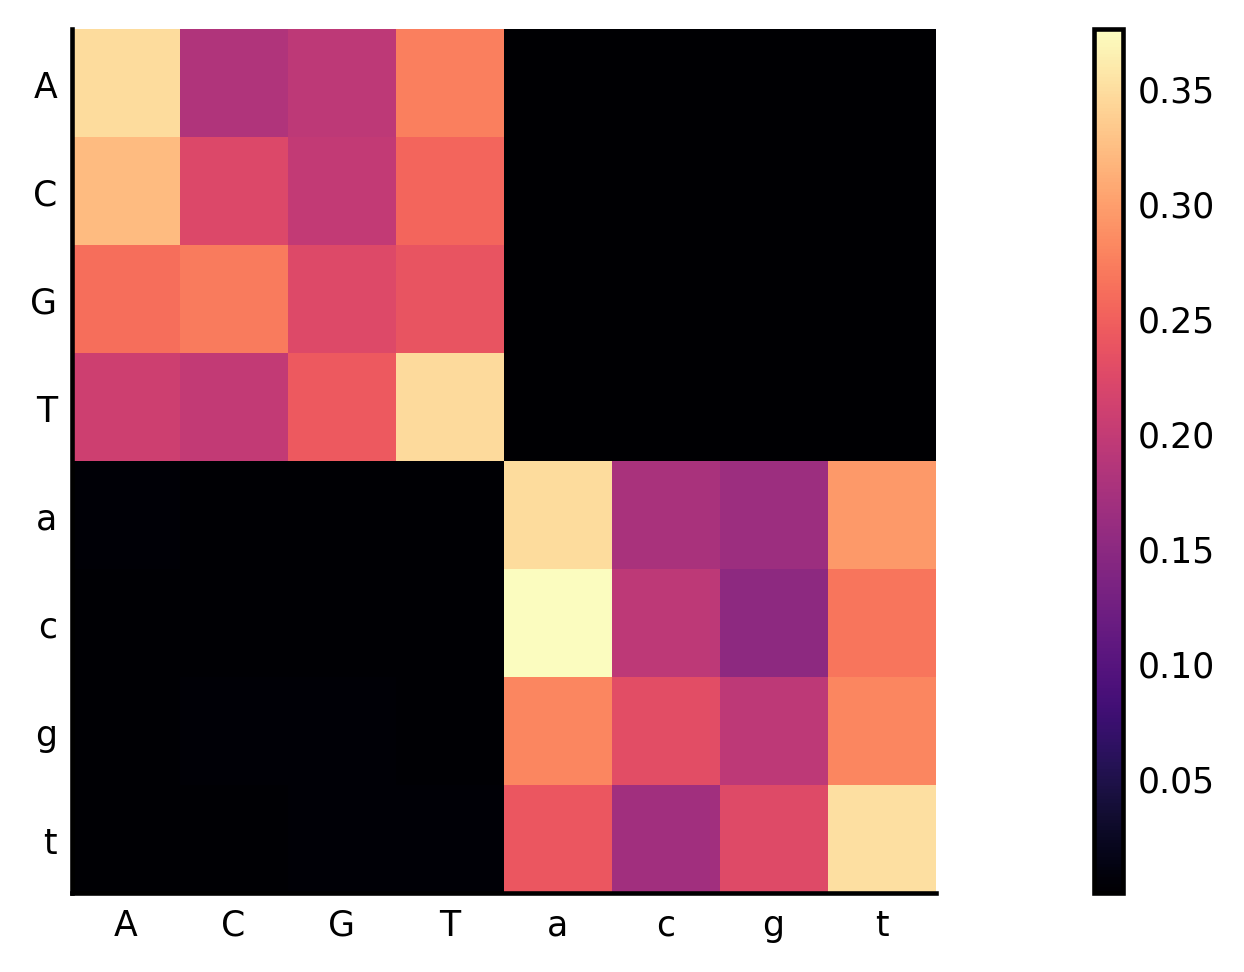

In [32]:
def plot_model(model, labels, figure=None):
    fig = figure or plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    im = ax.imshow(model, cmap='magma');
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.8])
    plt.colorbar(im, cax=axcolor)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_ticks(range(8))
        axis.set_ticks_position('none')
        axis.set_ticklabels(labels)
    return ax

plot_model(model, labels='ACGTacgt');